In [4]:
from pathlib import Path
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram as xhist
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatter 
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap
import re
import cmocean as cmo
from shapely.geometry import Polygon, Point

In [7]:
out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/"
year_list = np.arange(2007,2017).tolist()
out_files = sorted(Path(out_path).glob("*.nc"))
output_dt_in_h = 24

def read_output(file):    
    return xr.open_dataset(file)

def load_ds(zone = 1):
    
    out_path = "/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/"
    out_files = sorted(Path(out_path).glob(f"*zone{zone}*.nc"))

    ds = xr.concat(map(read_output, out_files), dim="traj")
    print(f'loaded {len(out_files)} files in zone {zone}')
    return ds, len(out_files)

def calculate_heatmap(output_dataset, lat_bins=None, lon_bins=None):
    heat_map = xhist(
        output_dataset.lat,
        output_dataset.lon,
        bins=[lat_bins, lon_bins],
        dim=["traj"],
    )
    
    heat_map = heat_map.where(heat_map > 0)
        
    return heat_map

def calc_mort_heatmap(data, lat_bins,lon_bins,photo = False ):
    
    data = data.copy()

    if photo:
        print('mortality; with photos.')
        m = -0.092683473
        data = data.isel(obs = slice(0,181))

    else:
        print('mortality; without photos.')
        m = -0.164783335
        data = data.isel(obs = slice(0,101))

    t = data.obs
    n0 = data.traj.size
    weight = xr.ones_like(data.obs)
    int_heat = calculate_heatmap(data.isel(obs = slice(0,-1)), lat_bins=lat_bins, lon_bins=lon_bins)
    mort_heatmap = (int_heat * weight[:-1]).sum('obs')
    #analytical integ. particles
    particle_sum = int(np.sum(n0 * np.exp(m*t)))
    #diff to integ.mortality heatmap
    err_diff = mort_heatmap.sum()-particle_sum
    print(f'Difference to integr. particles: {err_diff.values}')

    return mort_heatmap,weight#particle_sum

out_files[:5]

[PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/urchin_americas_zone1_2007_w01_RT-1460_N-40000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/urchin_americas_zone1_2007_w14_RT-1460_N-40000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/urchin_americas_zone1_2007_w27_RT-1460_N-40000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/urchin_americas_zone1_2007_w40_RT-1460_N-40000_seed-12345.nc'),
 PosixPath('/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/output_data/full_brazil_longterm/urchin_americas_zone1_2008_w01_RT-1460_N-40000_seed-12345.nc')]

In [8]:
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")
VIK_mask = xr.open_dataset('/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/suppl/1_mesh_mask.nc')
test = VIK_mask.nav_lon.squeeze() - VIK_mask.glamt.squeeze()
#nav_lon = glamt?, nav_lat = gphit
t_nav_lat = VIK_mask.nav_lat
t_nav_lon = VIK_mask.nav_lon
#Nav_lat, nav_lon = Tgrid 
#box = ((VIK_mask.nav_lat >= -30) & (VIK_mask.nav_lat <= 60) & 
#           (VIK_mask.nav_lon >= -90) & (VIK_mask.nav_lon <= 15))

#depth off deepes cell; no partial cells 
depth_tgrid = VIK_mask.gdept_1d.squeeze()[VIK_mask.mbathy.squeeze()]
#bathy = VIK_mask.mbathy.squeeze()
del VIK_mask

In [9]:
data_path = Path("/gxfs_work1/geomar/smomw355/model_data/ocean-only/VIKING20X.L46-KFS003/nemo/output/")
u_pat = [f"1_VIKING20X.L46-KFS003_1m_{year}*grid_U.nc" for year in year_list]
v_pat = [f"1_VIKING20X.L46-KFS003_1m_{year}*grid_V.nc" for year in year_list]

u_files = []
v_files = []
for i,upat in enumerate(u_pat):
    
    u_files.extend(Path(data_path).glob(u_pat[i]))
    v_files.extend(Path(data_path).glob(v_pat[i]))

In [10]:
#U_mean
calc_velocity = False

if calc_velocity:
    ds_u = xr.open_mfdataset(u_files[:],combine='nested', 
                                    concat_dim="time_counter", #use_cftime=True,
                                    data_vars='minimal', coords='minimal', compat='override',
                                    parallel=True
                        ).rename({'time_counter':'time'}).isel(depthu = slice(0,5))

    ds_u = ds_u.vozocrtx.drop_vars('time_centered').mean('depthu').mean('time')
    print(ds_u.nbytes/1e9)
    ds_u.compute()
    ds_u.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/u_mean.nc")
    
    #V_mean
    ds_v = xr.open_mfdataset(v_files[0],combine='nested', 
                                    concat_dim="time_counter", #use_cftime=True,
                                    data_vars='minimal', coords='minimal', compat='override',
                                    parallel=True
                        ).rename({'time_counter':'time'}).isel(depthv = slice(0,5))

    ds_v = ds_v.vomecrty.drop_vars('time_centered').mean('depthv').mean('time')
    print(ds_v.nbytes/1e9)
    ds_v.compute()
    ds_v.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/v_mean.nc")
    
else:
    ds_u = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/u_mean.nc")
    ds_v = xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/v_mean.nc")

In [11]:
#t_grid bathy
t_file = "1_VIKING20X.L46-KFS003_1d_20110101_20111231_grid_T.nc"
t = xr.open_dataset(data_path / t_file)
t = t.vosaline.sel(time_counter = "2011-01-01")

depth_ind = t.where(t == 0).fillna(1).sum(dim = "deptht").astype('int') #depth of cell
depth_tgrid_old =  t.deptht.isel(deptht = depth_ind)
del t

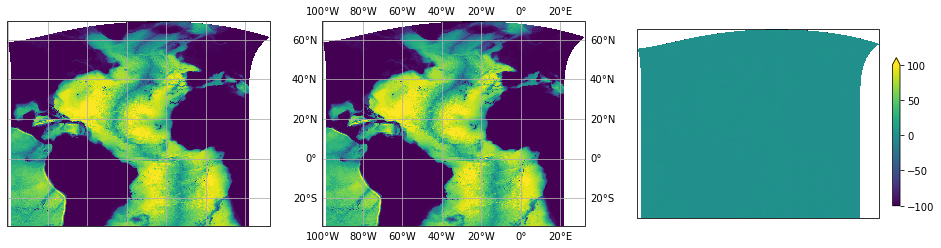

In [12]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(1, 3, subplot_kw={"projection": proj}, figsize=(16, 9))

ax[0].pcolormesh(t_nav_lon,t_nav_lat,depth_tgrid)
ax[0].gridlines()
ax[1].pcolormesh(depth_tgrid_old.nav_lon,depth_tgrid_old.nav_lat,depth_tgrid_old.squeeze())
ax[1].gridlines(draw_labels = True)
#depth_tgrid_old.squeeze().plot(ax = ax[1],x = 'nav_lon', y = 'nav_lat')
pc = ax[2].pcolormesh(t_nav_lon,t_nav_lat,depth_tgrid - depth_tgrid_old.squeeze(),vmin = -100,vmax = 100)
cbar = fig.colorbar(pc, ax =ax[2], pad = 0.05,fraction = 0.047*0.6, extend = 'max')

In [13]:
#coarse bins
calc_hm = False #wether to load or calc heamtmap 

dlat = 1 #binsize
dlon = 1

lat_bins = np.arange(-30, 60 + dlat, dlat)
lon_bins = np.arange(-90, 15 + dlon, dlon)
#load brazil
if calc_hm:
    ds,num = load_ds(1)
    hm_ens_mean = calculate_heatmap(ds,lat_bins,lon_bins)
    #hm_ens_mean.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmap_brazil_longerm.nc")
    del ds
else:
    hm_ens_mean =  xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmap_brazil_longerm.nc")

In [14]:
#hm_ens_mean.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmap_brazil_longerm.nc")
    #only on shelf
#afr_hm = np.where(bath_afr<500, ensemble_mean, np.nan)
#afr_hm100 = np.where(bath_afr<500, ensemble_100_mean, np.nan)

In [14]:
#release zone
#load polygon data
rel_zone_path = '/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/' 
box_brazil = Polygon(pd.read_csv(rel_zone_path+ 'release_zone_brazil.csv').values.tolist(), [])

# labelticks
x_lines = np.arange(-90,30,10).tolist()
y_lines = np.arange(-30,60,10).tolist()#

x_bin_mesh,y_bin_mesh = np.meshgrid(hm_ens_mean.lon_bin, hm_ens_mean.lat_bin)

proj = ccrs.PlateCarree()
cb_pad = 0.05
cb_fraction = 0.047*0.4

new_cmap = cmo.tools.crop_by_percent(cmo.cm.dense, 10, which='min', N=None)#25
formatter = LogFormatter(10, labelOnlyBase=False)

#BOxes
box_azores = ((y_bin_mesh >= 37) & (y_bin_mesh <= 39) & 
           (x_bin_mesh >= -30) & (x_bin_mesh <= -24.5))
box_azores = np.where(box_azores== True, 1 ,np.nan)

box_canary = ((y_bin_mesh >= 27.4) & (y_bin_mesh <= 29) & 
           (x_bin_mesh >= -18) & (x_bin_mesh <= -14))
box_canary = np.where(box_canary== True, 1 ,np.nan)

box_capverde = ((y_bin_mesh >= 15) & (y_bin_mesh <= 17) & 
           (x_bin_mesh >= -25) & (x_bin_mesh <= -22.5))
box_capverde = np.where(box_capverde== True, 1 ,np.nan)

In [15]:

hm_181 = hm_ens_mean.isel(obs = slice(0,181)).mean('obs')
hm_181 = np.where(hm_181>0,hm_181, np.nan)

hm_365 = hm_ens_mean.isel(obs = slice(0,365)).mean('obs')
hm_365 = np.where(hm_365>0,hm_365, np.nan)

hm_2y = hm_ens_mean.isel(obs = slice(0,730)).mean('obs')
hm_2y = np.where(hm_2y>0,hm_2y, np.nan)

hm_3y = hm_ens_mean.isel(obs = slice(0,1095)).mean('obs')
hm_3y = np.where(hm_3y>0,hm_3y, np.nan)

hm_4y = hm_ens_mean.isel(obs = slice(0,1461)).mean('obs')
hm_4y = np.where(hm_4y>0,hm_4y, np.nan)

In [162]:
qv_scale = .4
offset = 1
skip = 90

qv_x = ds_u.nav_lon[offset::skip,offset::skip], 
qv_y = ds_u.nav_lat[offset::skip,offset::skip], 

qv_u = ds_u[offset::skip,offset::skip] 
qv_v = ds_v[offset::skip,offset::skip]

limit = 0.2
vel = (qv_u**2 + qv_v**2)**.5
qv_u = xr.where(vel <= limit, qv_u,qv_u * (limit/vel))
qv_v = xr.where(vel <= limit, qv_v,qv_v * (limit/vel))

/opt/conda/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1666: UserWarning: The following kwargs were not used by contour: 'rasterized'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


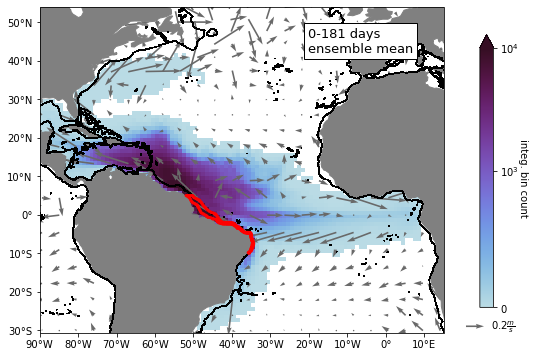

In [163]:
textbox = "0-181 days\nensemble mean"

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(13, 6))

pc = ax.pcolormesh(x_bin_mesh,y_bin_mesh,hm_181, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       vmin=0, vmax=10000, base=10))
cbar = fig.colorbar(pc, ax =ax, pad = cb_pad,fraction = cb_fraction, extend = 'max')


qv = ax.quiver(qv_x,qv_y,qv_u,qv_v, color = 'dimgray', scale = qv_scale, rasterized = True, #2.5
             scale_units='inches', width = .004,#zorder = -1,
                transform = proj)

ax.quiverkey(qv, 1.1, 0.02, .1, r'$0.2 \frac{m}{s}$', labelpos='E', 
                       coordinates='axes',rasterized = True,zorder = -1,);

cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
   
ax.annotate(textbox,(-20.3,42.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 13 )

ax.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
ax.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500], rasterized = True)
    
#ax.gridlines(zorder = 1)
ax.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
ax.set_xticks(x_lines, crs=proj)
ax.set_yticks(y_lines, crs=proj)
ax.set_extent((-90,15,-20,40))
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter()) 
plt.savefig('pics/americas_hm_brazil_longterm_181.svg', format = 'svg', dpi = 700)  
#plt.savefig('pics/americas_hm_brazil_longterm_181.png', dpi = 300, bbox_inches = 'tight')

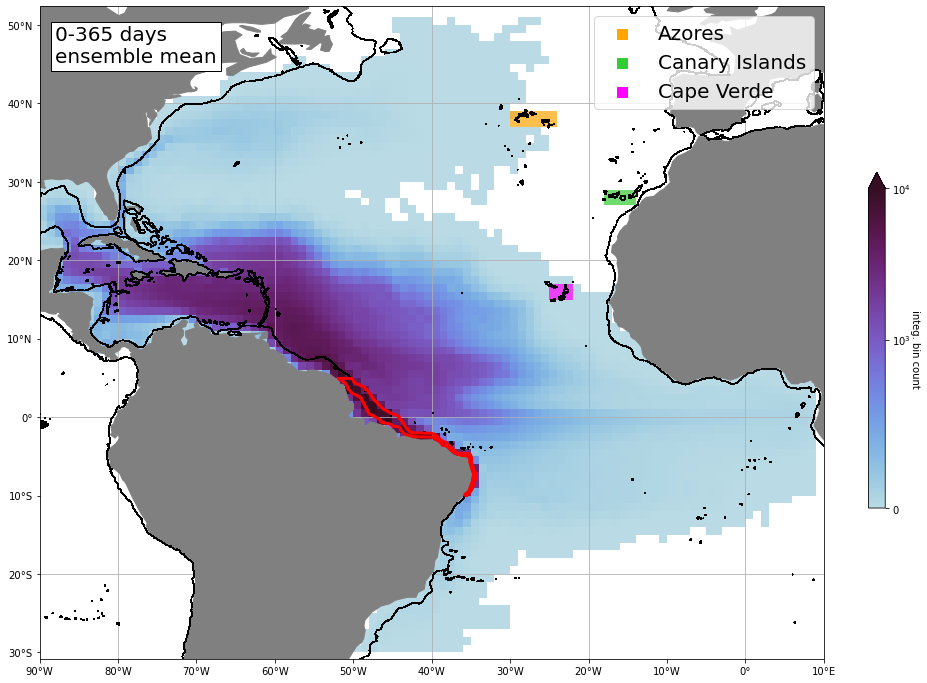

In [50]:
textbox = "0-365 days\nensemble mean"
textbox2 = "a)"

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(16, 12))

pc = axs.pcolormesh(x_bin_mesh,y_bin_mesh,hm_365, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       vmin=0, vmax=10000, base=10))#, zorder = ))


cbar = fig.colorbar(pc, ax =axs, pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
#
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_azores,cmap = ListedColormap(['orange']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_canary,cmap = ListedColormap(['limegreen']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_capverde,cmap = ListedColormap(['magenta']), alpha = .7) 
#for legend

axs.scatter(170,0, s = 100, color = 'orange',marker = 's', label = 'Azores',rasterized = True)
axs.scatter(170,0, s = 100, color = 'limegreen',marker = 's', label = 'Canary Islands',rasterized = True)
axs.scatter(170,0, s = 100, color = 'magenta',marker = 's', label = 'Cape Verde',rasterized = True)

axs.annotate(textbox,(-88,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 20 )
#axs.annotate(textbox2,(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 16 )
axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
axs.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
axs.gridlines(zorder = 1)

axs.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
axs.set_xticks(x_lines, crs=proj)
axs.set_yticks(y_lines, crs=proj)
axs.set_extent((-90,10,-21,40))
axs.xaxis.set_major_formatter(LongitudeFormatter())
axs.yaxis.set_major_formatter(LatitudeFormatter()) 
axs.legend(fontsize = 20)
plt.savefig('pics/americas_hm_brazil_longterm_1y.png', dpi = 300, bbox_inches = 'tight')

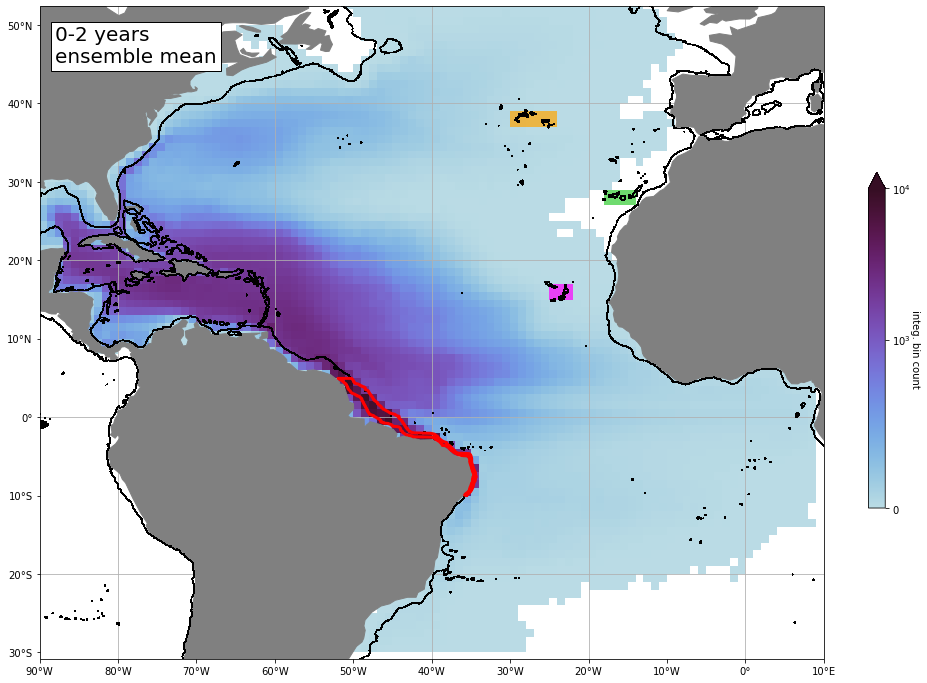

In [51]:
textbox = "0-2 years\nensemble mean"

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(16, 12))

pc = axs.pcolormesh(x_bin_mesh,y_bin_mesh,hm_2y, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       vmin=0, vmax=10000, base=10))#, zorder = ))


cbar = fig.colorbar(pc, ax =axs, pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
#
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_azores,cmap = ListedColormap(['orange']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_canary,cmap = ListedColormap(['limegreen']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_capverde,cmap = ListedColormap(['magenta']), alpha = .7) 
#for legend

axs.scatter(170,0, s = 100, color = 'orange',marker = 's', label = 'Azores',rasterized = True)
axs.scatter(170,0, s = 100, color = 'limegreen',marker = 's', label = 'Canary Islands',rasterized = True)
axs.scatter(170,0, s = 100, color = 'magenta',marker = 's', label = 'Cape Verde',rasterized = True)

axs.annotate(textbox,(-88,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 20 )
#axs.annotate(textbox2,(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 16 )
axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
axs.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
axs.gridlines(zorder = 1)

axs.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
axs.set_xticks(x_lines, crs=proj)
axs.set_yticks(y_lines, crs=proj)
axs.set_extent((-90,10,-21,40))
axs.xaxis.set_major_formatter(LongitudeFormatter())
axs.yaxis.set_major_formatter(LatitudeFormatter()) 
#axs.legend(fontsize = 20)
plt.savefig('pics/americas_hm_brazil_longterm_2y.png', dpi = 300, bbox_inches = 'tight')

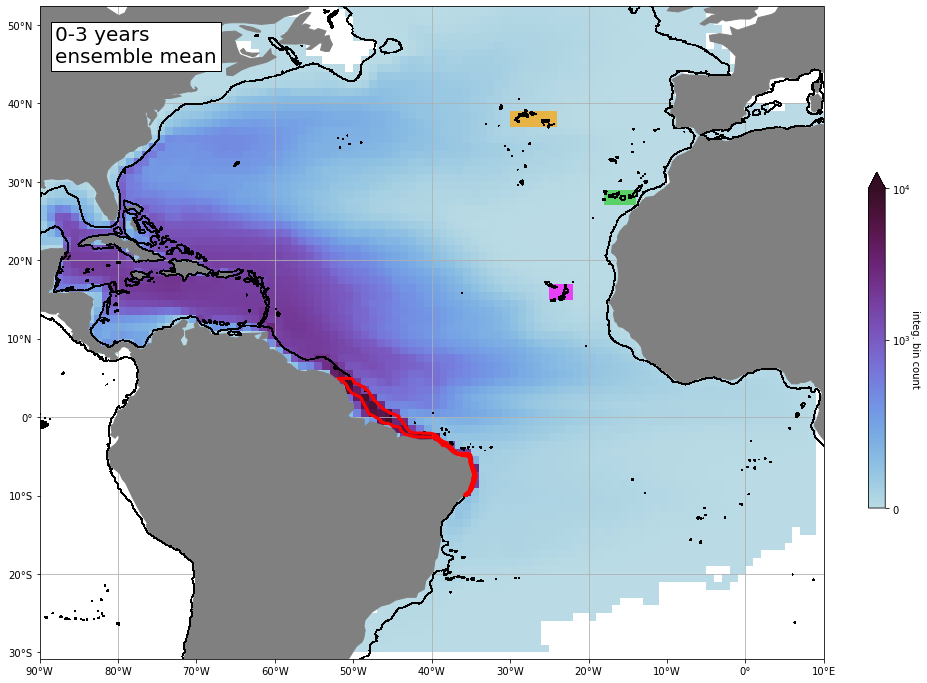

In [52]:
textbox = "0-3 years\nensemble mean"

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(16, 12))

pc = axs.pcolormesh(x_bin_mesh,y_bin_mesh,hm_3y, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       vmin=0, vmax=10000, base=10))#, zorder = ))


cbar = fig.colorbar(pc, ax =axs, pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
#
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_azores,cmap = ListedColormap(['orange']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_canary,cmap = ListedColormap(['limegreen']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_capverde,cmap = ListedColormap(['magenta']), alpha = .7) 
#for legend

axs.scatter(170,0, s = 100, color = 'orange',marker = 's', label = 'Azores',rasterized = True)
axs.scatter(170,0, s = 100, color = 'limegreen',marker = 's', label = 'Canary Islands',rasterized = True)
axs.scatter(170,0, s = 100, color = 'magenta',marker = 's', label = 'Cape Verde',rasterized = True)

axs.annotate(textbox,(-88,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 20 )
#axs.annotate(textbox2,(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 16 )
axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
axs.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
axs.gridlines(zorder = 1)

axs.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
axs.set_xticks(x_lines, crs=proj)
axs.set_yticks(y_lines, crs=proj)
axs.set_extent((-90,10,-21,40))
axs.xaxis.set_major_formatter(LongitudeFormatter())
axs.yaxis.set_major_formatter(LatitudeFormatter()) 
#axs.legend(fontsize = 20)
plt.savefig('pics/americas_hm_brazil_longterm_3y.png', dpi = 300, bbox_inches = 'tight')

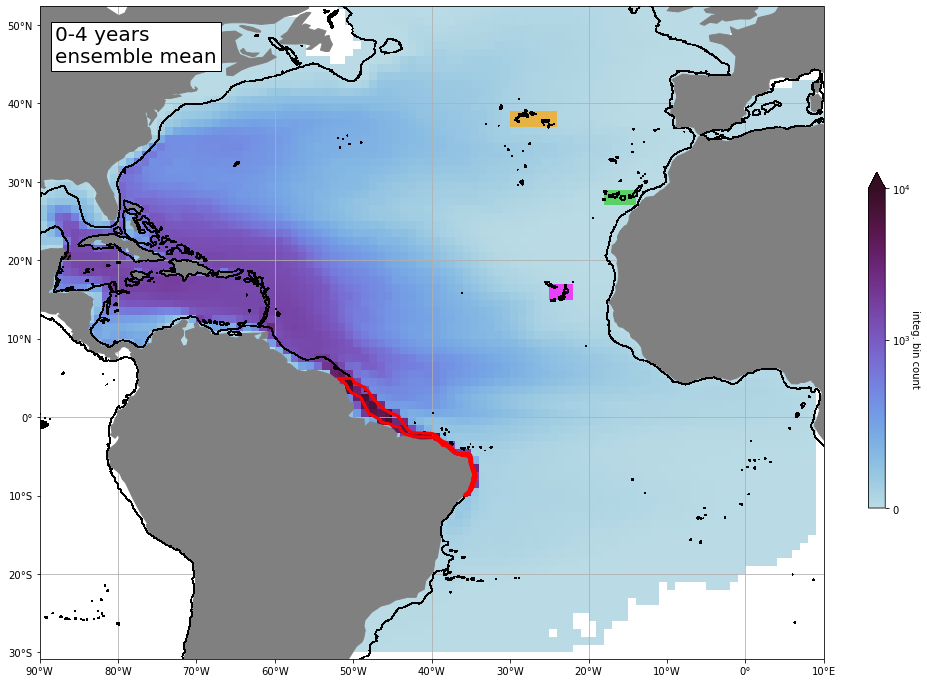

In [53]:
textbox = "0-4 years\nensemble mean"

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(16, 12))

pc = axs.pcolormesh(x_bin_mesh,y_bin_mesh,hm_4y, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=1000, linscale=1,
                                                       vmin=0, vmax=10000, base=10))#, zorder = ))


cbar = fig.colorbar(pc, ax =axs, pad = cb_pad,fraction = cb_fraction, extend = 'max')
cbar.set_label('integ. bin count', rotation=270, labelpad = 9)
#
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_azores,cmap = ListedColormap(['orange']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_canary,cmap = ListedColormap(['limegreen']), alpha = .7) 
axs.pcolormesh(x_bin_mesh,y_bin_mesh,box_capverde,cmap = ListedColormap(['magenta']), alpha = .7) 
#for legend

axs.scatter(170,0, s = 100, color = 'orange',marker = 's', label = 'Azores',rasterized = True)
axs.scatter(170,0, s = 100, color = 'limegreen',marker = 's', label = 'Canary Islands',rasterized = True)
axs.scatter(170,0, s = 100, color = 'magenta',marker = 's', label = 'Cape Verde',rasterized = True)

axs.annotate(textbox,(-88,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 20 )
#axs.annotate(textbox2,(-87.5,45.2),bbox={"fc": "white", "ec": "k", "lw": 1}, fontsize = 16 )
axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
axs.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.8,antialiased = False, levels = [500])
    
axs.gridlines(zorder = 1)

axs.plot(box_brazil.exterior.coords.xy[0],box_brazil.exterior.coords.xy[1],ls = 'solid', c = 'red',lw = 3)
axs.set_xticks(x_lines, crs=proj)
axs.set_yticks(y_lines, crs=proj)
axs.set_extent((-90,10,-21,40))
axs.xaxis.set_major_formatter(LongitudeFormatter())
axs.yaxis.set_major_formatter(LatitudeFormatter()) 
#axs.legend(fontsize = 20)
plt.savefig('pics/americas_hm_brazil_longterm_4y.png', dpi = 300, bbox_inches = 'tight')

In [54]:
# count Archipelo
sum_azores = np.zeros(1461)
sum_canary = np.zeros(1461)
sum_capverde = np.zeros(1461)

for i in range(sum_azores.shape[0]):

    hm_day = hm_ens_mean.isel(obs = i)
    sum_azores[i] = (hm_day*box_azores).sum()
    sum_canary[i] = (hm_day*box_canary).sum()
    sum_capverde[i] = (hm_day*box_capverde).sum()

In [55]:
#first particel at day
first_azores = np.where(sum_azores> 0)[0][0] +1
first_canary = np.where(sum_canary > 0)[0][0] +1
first_capverde = np.where(sum_capverde > 0)[0][0] +1

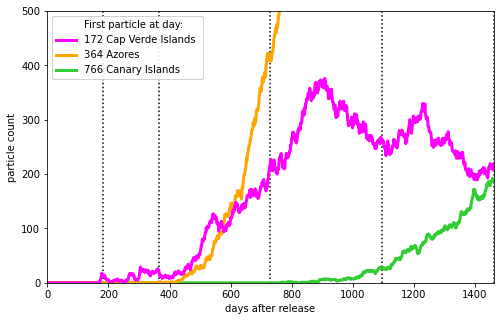

In [57]:
plt.figure(figsize = (8,5))

plt.vlines(181,0,500,ls = ':', color = '00', zorder = -1)
plt.vlines(365,0,500,ls = ':', color = '00', zorder = -1)
plt.vlines(730,0,500,ls = ':', color = '00', zorder = -1)
plt.vlines(1095,0,500,ls = ':', color = '00', zorder = -1)
plt.vlines(1461,0,500,ls = ':', color = '00', zorder = -1)

plt.scatter(0,-1, alpha = 0,label = 'First particle at day:')
plt.plot(sum_capverde, label = f'{first_capverde} Cap Verde Islands ', lw = 3, c = 'magenta', zorder = 2)
plt.plot(sum_azores, label = f'{first_azores} Azores            ', lw = 3, color = 'orange',zorder = 1)
plt.plot(sum_canary, label = f'{first_canary} Canary Islands   ', lw = 3, color= 'limegreen',zorder = 0)

#vlines


plt.xlabel('days after release')
plt.ylabel('particle count')
plt.xlim(0,1461)
plt.ylim(0,500)
plt.legend(loc = 'upper left',framealpha = 0.9)
plt.savefig('pics/americas_count_archpelagos.png', dpi = 300, bbox_inches = 'tight')

In [24]:
ds,num = load_ds(1)

loaded 5 files in zone 1


In [74]:
## count high resolution histogramm
hres_hist_box = ((t_nav_lat >= 12) & (t_nav_lat <= 39.5) & 
           (t_nav_lon >= -30) & (t_nav_lon <= -10))

hist_bathy_box = depth_tgrid_old.where(hres_hist_box, drop=True).squeeze()#.isel(x = slice(1,None),y = slice(1,None))

lon_bins = hist_bathy_box.nav_lon[300,:].values
lat_bins = hist_bathy_box.nav_lat[:,200].values

x_bin_mesh,y_bin_mesh = np.meshgrid(lon_bins,lat_bins)

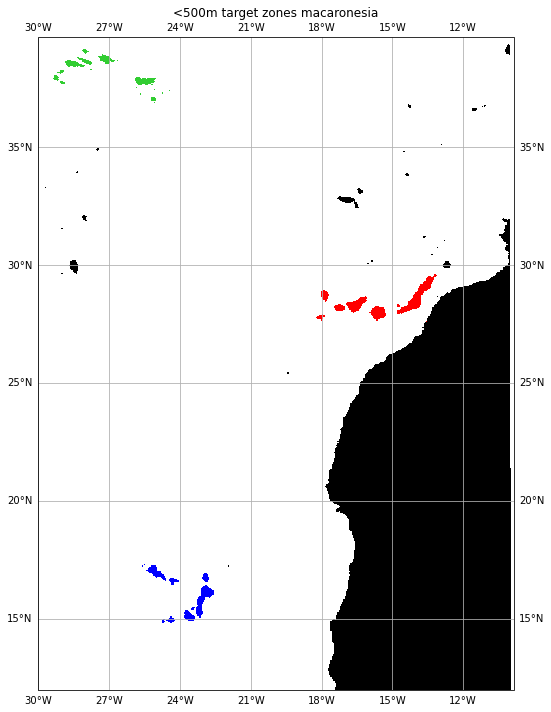

In [125]:
#archipelago masks
dm = hist_bathy_box.where((hist_bathy_box <500))

fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(12, 12))
dm.plot(ax =axs,x = 'nav_lon', y = 'nav_lat', cmap = ListedColormap('00'), add_colorbar = False)

#AZ
bath_azores =  dm.where((dm['nav_lat'] >=35.65)&(dm['nav_lon'] <=-24))
bath_azores.plot(x = 'nav_lon', y = 'nav_lat',cmap = ListedColormap('limegreen'),add_colorbar = False)

bath_canary = dm.where((dm['nav_lat'] >=27.6)&(dm['nav_lat'] <=30)&
                      (dm['nav_lon'] >=-19)&(dm['nav_lon'] <=-13.5))
bath_canary2 = dm.where((dm['nav_lat'] >=28.9)&(dm['nav_lat'] <=29.8)&
                      (dm['nav_lon'] >=-15)&(dm['nav_lon'] <=-13))
bath_canary = (bath_canary.fillna(0)  +bath_canary2.fillna(0)).where((bath_canary.fillna(0)  +bath_canary2.fillna(0))>0)
bath_canary.plot(x = 'nav_lon', y = 'nav_lat',cmap = ListedColormap('red'),add_colorbar = False)


bath_capverde =  dm.where((dm['nav_lat'] <=19)&(dm['nav_lon'] <=-22))
bath_capverde.plot(x = 'nav_lon', y = 'nav_lat',cmap = ListedColormap('blue'),add_colorbar = False)


axs.gridlines(draw_labels=True)
axs.set_title('<500m target zones macaronesia')
plt.savefig('pics/target_zones_macaronesia.png', dpi = 300, bbox_inches = 'tight')

In [76]:
#calc or load heatmap

#hm_ens_mean =  xr.open_dataarray("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmap_highres_brazil_longerm.nc")
hm_ens_mean = calculate_heatmap(ds,lat_bins,lon_bins)

hm_ens_mean.to_netcdf("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/heatmap_highres_brazil_longerm.nc")
hm_ens_mean.nbytes

2895929600

In [77]:
hm_ens_mean.isel(obs = 150)

<xarray.DataArray 'histogram_lat_lon' (lat_bin: 619, lon_bin: 400)>
array([[ 1., nan, nan, ..., nan, nan, nan],
       [nan,  1., nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat_bin  (lat_bin) float32 12.04 12.08 12.13 12.18 ... 39.49 39.53 39.57
  * lon_bin  (lon_bin) float32 -29.98 -29.93 -29.88 ... -10.12 -10.07 -10.02

In [94]:
#count

# count Archipelo
sum_azores = np.zeros(1461)
sum_canary = np.zeros(1461)
sum_capverde = np.zeros(1461)

for i in range(sum_azores.shape[0]):

    hm_day = hm_ens_mean.isel(obs = i)
    sum_azores[i] = (hm_day*np.where(bath_azores>0, 1 ,np.nan)).sum()
    sum_canary[i] = (hm_day*np.where(bath_canary>0, 1 ,np.nan)).sum()
    sum_capverde[i] = (hm_day*np.where(bath_capverde>0, 1 ,np.nan)).sum()

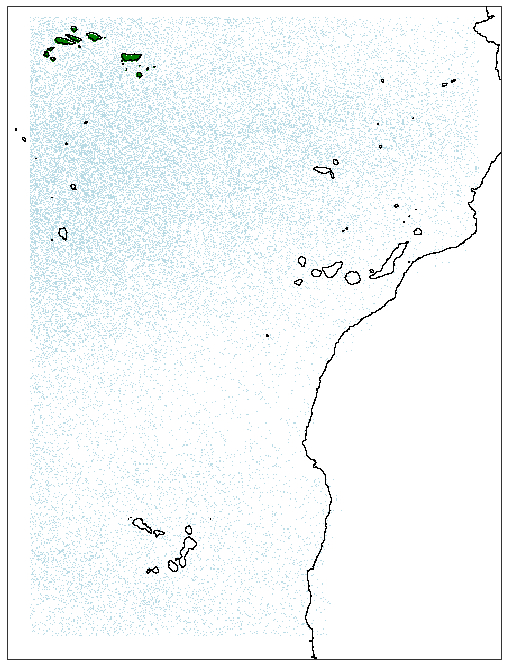

In [93]:
fig, axs = plt.subplots(1, 1, subplot_kw={"projection": proj}, figsize=(16, 12))

pc = axs.pcolormesh(x_bin_mesh,y_bin_mesh,hm_day, cmap = new_cmap, rasterized = True , norm=colors.SymLogNorm(linthresh=100, linscale=1,
                                                       vmin=0, vmax=1000, base=10))#, zorder = ))

#axs.add_feature(cpf.LAND,facecolor='gray',zorder = 2, rasterized = True)
axs.contour(t_nav_lon,t_nav_lat, depth_tgrid.squeeze(), colors = "00", linewidths = 0.1,antialiased = False, levels = [500])
#bath_capverde.plot(ax = axs,x = 'nav_lon', y = 'nav_lat',cmap = ListedColormap('blue'),add_colorbar = False)
axs.pcolormesh(x_bin_mesh,y_bin_mesh,np.where(bath_azores>0, 1 ,np.nan), cmap = ListedColormap('green'))
axs.set_extent((-31,-9,11,40))

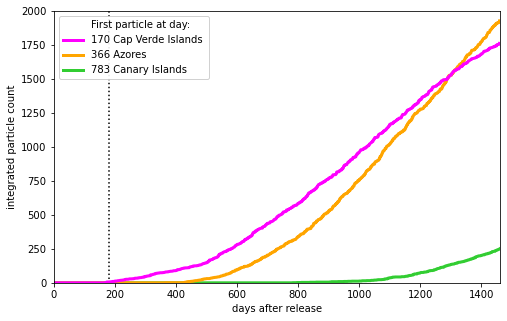

In [124]:
#first particel at day
first_azores = np.where(sum_azores> 0)[0][0] 
first_canary = np.where(sum_canary > 0)[0][0] 
first_capverde = np.where(sum_capverde > 0)[0][0] 

def count_in_shallow(mean_sum):
    return np.cumsum(np.where(np.ediff1d(mean_sum)>0, np.ediff1d(mean_sum),0))

plt.figure(figsize = (8,5))

plt.vlines(181,0,2000,ls = ':', color = '00', zorder = -1)
#plt.vlines(365,0,500,ls = ':', color = '00', zorder = -1)
#plt.vlines(730,0,500,ls = ':', color = '00', zorder = -1)
#plt.vlines(1095,0,500,ls = ':', color = '00', zorder = -1)
#plt.vlines(1461,0,500,ls = ':', color = '00', zorder = -1)

plt.scatter(0,-1, alpha = 0,label = 'First particle at day:')
plt.plot(count_in_shallow(sum_capverde), label = f'{first_capverde} Cap Verde Islands ', lw = 3, c = 'magenta', zorder = 2)
plt.plot(count_in_shallow(sum_azores), label = f'{first_azores} Azores            ', lw = 3, color = 'orange',zorder = 1)
plt.plot(count_in_shallow(sum_canary), label = f'{first_canary} Canary Islands   ', lw = 3, color= 'limegreen',zorder = 0)

#vlines


plt.xlabel('days after release')
plt.ylabel('integrated particle count')
plt.xlim(0,1461)
plt.ylim(0,2000)
plt.legend(loc = 'upper left',framealpha = 0.9)
plt.savefig('pics/americas_count_archpelagos.png', dpi = 300, bbox_inches = 'tight')

In [123]:
#
arr1 = count_in_shallow(sum_capverde).astype(int)
arr2 = count_in_shallow(sum_azores).astype(int)
arr3 = count_in_shallow(sum_canary).astype(int)

data = pd.DataFrame({'Cap Verde': arr1, 'Azores': arr2, 'Canary': arr3})

data.to_csv("/gxfs_work1/geomar/smomw529/2023_sea_urchin_tenerife/data/brazil_release_macaronesia_count.csv", index=False)
       